<a href="https://colab.research.google.com/github/cheikhb/ML_Projects/blob/main/ML_with_LIME%26H2O_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this project we are going do explainable machine learning with LIME and H2O in R**

In [1]:
install.packages("tidyverse")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Now lets install Lime, Recipes and H2O packages 

In [2]:
install.packages("lime")
install.packages("h2o")
install.packages("recipes")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘fastmap’, ‘glmnet’, ‘shiny’, ‘shinythemes’, ‘gower’, ‘RcppEigen’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘RCurl’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘ipred’, ‘timeDate’




In [3]:
library(tidyverse)
library(h2o)
library(lime)
library(recipes)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse

**Now we are going to load our dataset**

In [4]:
hr_data_raw <- read_csv("/content/HR-Employee-Attrition.csv")
hr_data_raw[1:10,]


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  Attrition = col_character(),
  BusinessTravel = col_character(),
  Department = col_character(),
  EducationField = col_character(),
  Gender = col_character(),
  JobRole = col_character(),
  MaritalStatus = col_character(),
  Over18 = col_character(),
  OverTime = col_character()
)
ℹ Use `spec()` for the full column specifications.




Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6
59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,⋯,1,80,3,12,3,2,1,0,0,0
30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,1,11,⋯,2,80,1,1,2,3,1,0,0,0
38,No,Travel_Frequently,216,Research & Development,23,3,Life Sciences,1,12,⋯,2,80,0,10,2,3,9,7,1,8


**Data Processing**

Lets convert non numerical variables to be factors

In [5]:
hr_data <- hr_data_raw %>%
    mutate_if(is.character, as.factor) %>%
    select(Attrition, everything())

In [6]:
recipe_data <- hr_data %>%
  recipe(formula = Attrition ~ .) %>%
  step_rm(EmployeeNumber) %>%
  step_zv(all_predictors()) %>%
  step_center(all_numeric()) %>%
  step_scale(all_numeric()) %>%
  prep(data = hr_data)

In [7]:
hr_data <- bake(recipe_data, new_data = hr_data) 
glimpse(hr_data)

Rows: 1,470
Columns: 31
$ Age                      <dbl> 0.44619856, 1.32191535, 0.00834016, -0.42951…
$ BusinessTravel           <fct> Travel_Rarely, Travel_Frequently, Travel_Rar…
$ DailyRate                <dbl> 0.74227393, -1.29733311, 1.41388208, 1.46096…
$ Department               <fct> Sales, Research & Development, Research & De…
$ DistanceFromHome         <dbl> -1.01056544, -0.14709966, -0.88721318, -0.76…
$ Education                <dbl> -0.89138490, -1.86779013, -0.89138490, 1.061…
$ EducationField           <fct> Life Sciences, Life Sciences, Other, Life Sc…
$ EnvironmentSatisfaction  <dbl> -0.6603060, 0.2545383, 1.1693826, 1.1693826,…
$ Gender                   <fct> Female, Male, Male, Female, Male, Male, Fema…
$ HourlyRate               <dbl> 1.38266773, -0.24059489, 1.28428818, -0.4865…
$ JobInvolvement           <dbl> 0.379543, -1.025818, -1.025818, 0.379543, 0.…
$ JobLevel                 <dbl> -0.05776789, -0.05776789, -0.96115930, -0.96…
$ JobRole                  <

Lets start the H2O cluster and create our train and test sets.

In [8]:
h2o.init(max_mem_size = "4g")


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/Rtmp94BoJJ/file3734821587/h2o_UnknownUser_started_from_r.out
    /tmp/Rtmp94BoJJ/file374a773ca3/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: .... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         3 seconds 359 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.32.0.1 
    H2O cluster version age:    1 month and 12 days  
    H2O cluster name:           H2O_started_from_R_root_gxy296 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   4.00 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extens

Train, valid and Test splits

In [9]:
set.seed(1234)
hr_data_h2o <- as.h2o(hr_data)

  |======================================================================| 100%


In [10]:
splits <- h2o.splitFrame(hr_data_h2o, c(0.7, 0.15), seed = 1234)

train, valid and test data

In [11]:
train <- h2o.assign(splits[[1]], "train" )
valid <- h2o.assign(splits[[2]], "valid" )
test  <- h2o.assign(splits[[3]], "test" )

**Lets Run AutoML to Train and Tune Models**

In [12]:
y <- "Attrition"
x <- setdiff(names(train), y)


In [13]:
aml <- h2o.automl(x = x, 
                  y = y,
                  training_frame = train,
                  leaderboard_frame = valid,
                  #max_runtime_secs  = 300,
                  max_runtime_secs = 60)

  |======================================================================| 100%


**Leaderboard Exploration**

In [14]:
lb <- aml@leaderboard
print(lb, n=nrow(lb))
best_model <- aml@leader
model_ids <-as.data.frame(aml@leaderboard$model_id)[,1]
best_model <- h2o.getModel(grep("StackedEnsemble_BestOfFamily", model_ids, value=TRUE)[1])

                                              model_id       auc   logloss
1  StackedEnsemble_BestOfFamily_AutoML_20201121_160039 0.8072114 0.3638072
2     StackedEnsemble_AllModels_AutoML_20201121_160039 0.8024135 0.3777907
3                     XGBoost_3_AutoML_20201121_160039 0.7976156 0.3758660
4       XGBoost_grid__1_AutoML_20201121_160039_model_2 0.7897645 0.3890092
5                     XGBoost_2_AutoML_20201121_160039 0.7848212 0.3787711
6                         GLM_1_AutoML_20201121_160039 0.7830765 0.4164302
7       XGBoost_grid__1_AutoML_20201121_160039_model_4 0.7813318 0.3822770
8                         GBM_4_AutoML_20201121_160039 0.7790782 0.3945454
9       XGBoost_grid__1_AutoML_20201121_160039_model_1 0.7763885 0.3872965
10      XGBoost_grid__1_AutoML_20201121_160039_model_5 0.7723175 0.3896328
11      XGBoost_grid__1_AutoML_20201121_160039_model_3 0.7714452 0.3954400
12          GBM_grid__1_AutoML_20201121_160039_model_2 0.7582146 0.4003468
13          GBM_grid__1_A

**Lets Evaluate ou Model Performance**

In [15]:
perf <- h2o.performance(best_model, newdata = test)
optimal_threshold <- h2o.find_threshold_by_max_metric(perf, "f1")
metrics <- as.data.frame(h2o.metric(perf, optimal_threshold))
t(metrics)

,43
f1,0.5833333
f2,0.6603774
f0point5,0.5223881
accuracy,0.8578199
precision,0.4883721
recall,0.7241379
specificity,0.8791209
absolute_mcc,0.5156434
min_per_class_accuracy,0.7241379
mean_per_class_accuracy,0.8016294


**Baselearner Variable Importance**

In [16]:
explainer <- lime(as.data.frame(train[,-31]), best_model, bin_continuous=FALSE)
explanation <- explain(as.data.frame(test[3:10, -31]),
                       explainer = explainer,
                       kernel_width = 1,
                       n_features = 5, 
                       n_labels = 1)

Warning message:
“PerformanceRating does not contain enough variance to use quantile binning. Using standard binning instead.”


  |======================================================================| 100%
  |======================================================================| 100%


In [23]:
knitr::opts_chunk$set(fig.width=800, fig.height=800) 


Lets plot the futures explanation

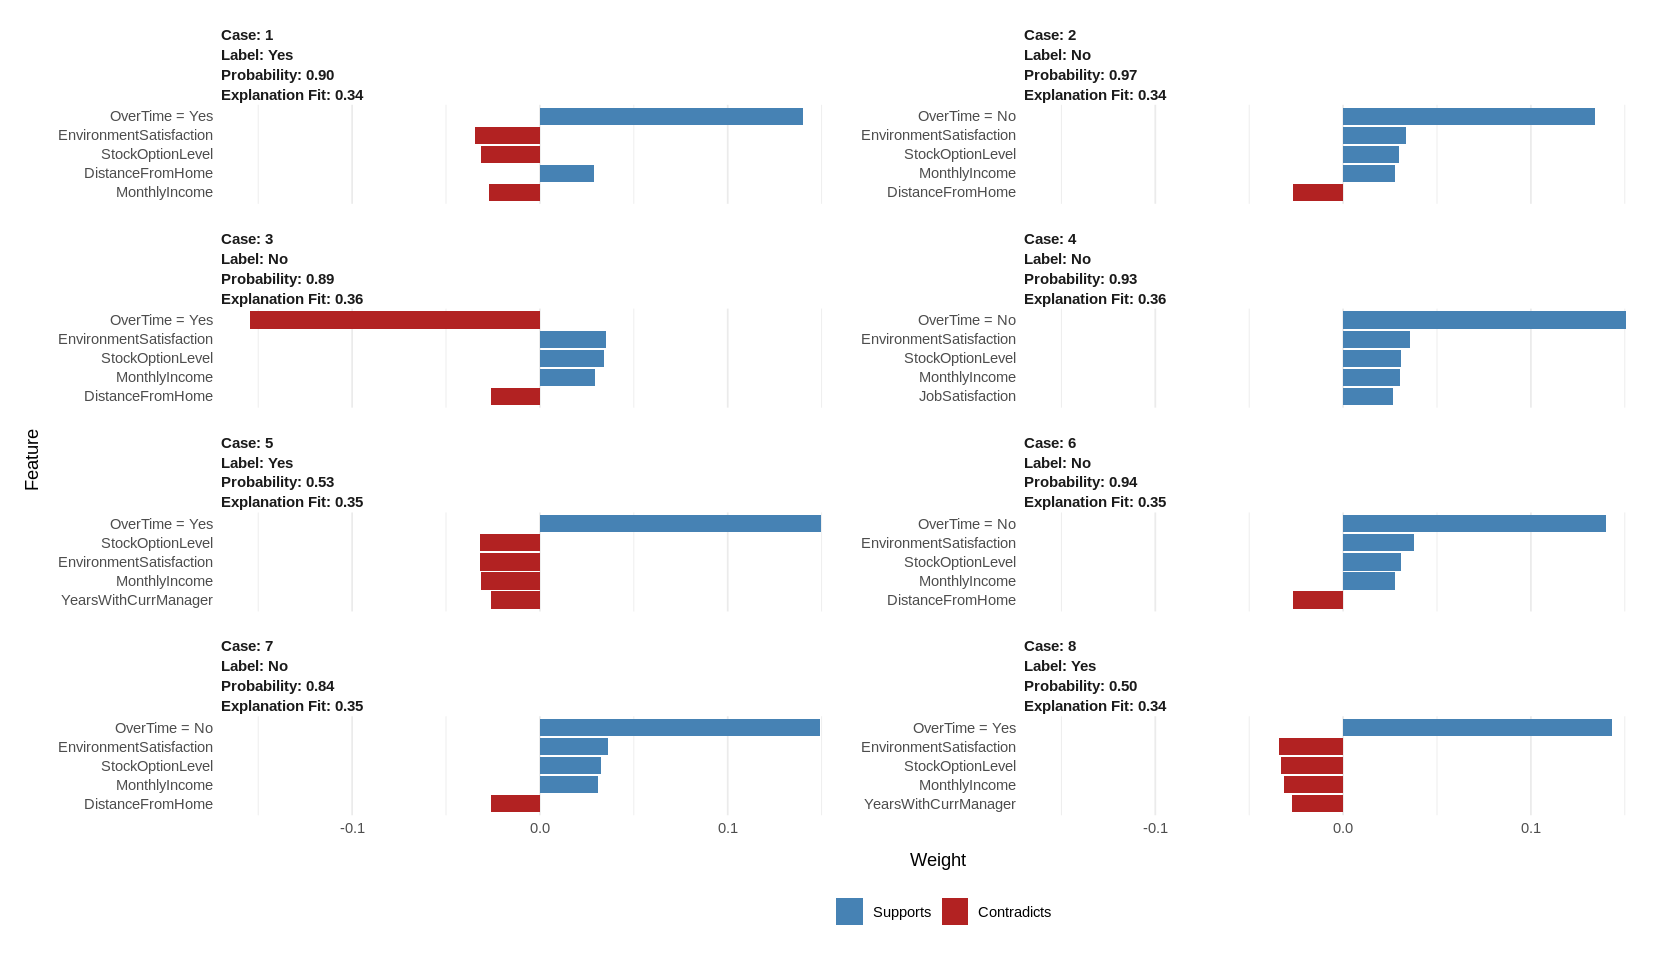

In [26]:
plot_features(explanation)
options(repr.plot.width = 800, repr.plot.height = 800)

Lets plot the explanations 

In [ ]:
plot_explanations(explanation)
